# Golf Training Session Analysis

This project analyzes my personal golf training data to identify strengths and weaknesses in my performance. The goal is to make data-driven decisions about which aspects of my swing and ball flight to focus on in future practice sessions.

The project includes:
- Data preprocessing and cleanup
- Exploratory data analysis (EDA)
- Visualizations of key performance metrics
- Identification of trends and outliers

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import numpy as np
import mplcursors as mplc
import math
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model, metrics
import statsmodels.formula.api as smf

import glob
import os

import requests
from bs4 import BeautifulSoup
from PIL import Image

## The Dataset

This dataset consists of real shot data collected using a golf launch monitor. Each row represents a shot, with columns capturing various metrics including:

- **Swing Speed** (mph)
- **Ball Speed** (mph)
- **Launch Angle** (degrees)
- **Spin Rate** (rpm)
- **Carry Distance** (yards)
- **Lateral Carry Distance**
- **Club Type**
- **Spin Axis**
- **Shot Shape**

The data was collected over multiple sessions and downloaded as `.csv` files, which were then merged and analyzed.

In [2]:
#function to read in all csv files from a specified location
def read_all_files(folder_path, file_extension='csv'):

    all_files = glob.glob(os.path.join(folder_path, f"*.{file_extension}"))
    if not all_files:
        return pd.DataFrame()

    all_df = []
    for f in all_files:
        df = pd.read_csv(f)
        all_df.append(df)

    combined_df = pd.concat(all_df, ignore_index=True)

    print(len(all_files), 'files imported from directory: ', folder_path)
    
    return combined_df

In [3]:
folder_path = 'shot_csvs'
file_extension = 'csv'

df = read_all_files(folder_path, file_extension)


5 files imported from directory:  shot_csvs


## Exploratory Data Analysis (EDA) and Cleanup

The first step is to explore the dataset to understand the distribution of values, identify missing data, and detect any anomalies. This includes:

- Examining data types and summary statistics
- Checking for missing or null values
- Standardizing column names
- Parsing and converting date information
- Ensuring all numerical values are properly formatted

In [4]:
df.head()

,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,Smash,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,NaN,NaN,NaN,[ft],[mph],[mph],[yd],[yd],[yd],NaN,...,[rpm],[deg],NaN,[in],[deg],[deg],[deg],[deg],[deg],NaN
1,2025-03-12 18:32:51,8 Iron,NaN,5600.00,82.77,104.91,155.81,167.08,11.28,1.27,...,7457,6.20,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Fade
2,2025-03-12 18:33:08,8 Iron,NaN,5600.00,82.77,105.14,158.74,172.98,14.24,1.27,...,6321,-6.10,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull Draw
3,2025-03-12 18:33:33,8 Iron,NaN,5600.00,82.77,106.48,159.80,171.36,11.56,1.29,...,7405,2.00,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull
4,2025-03-12 18:33:56,8 Iron,NaN,5600.00,83.89,108.49,163.69,174.70,11.00,1.29,...,7245,-0.50,Actual,NaN,NaN,NaN,NaN,NaN,NaN,Pull


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485 entries, 0 to 484
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    480 non-null    object 
 1   Club Type               480 non-null    object 
 2   Club Description        0 non-null      float64
 3   Altitude                485 non-null    object 
 4   Club Speed              485 non-null    object 
 5   Ball Speed              485 non-null    object 
 6   Carry Distance          485 non-null    object 
 7   Total Distance          485 non-null    object 
 8   Roll Distance           485 non-null    object 
 9   Smash                   480 non-null    float64
 10  Vertical Launch         485 non-null    object 
 11  Peak Height             485 non-null    object 
 12  Descent Angle           485 non-null    object 
 13  Horizontal Launch       485 non-null    object 
 14  Carry Lateral Distance  485 non-null    ob

In [6]:
# Dropping any rows that have 'Club Path' data. 
# The radar/camera device did not collect any Club Path data, so this should be null for all rows
# The rows that are not null, contain units of measure for each column which we do not need
df = df[df['Club Path'].isnull()]


# Dropping columns that won't be used and/or were not collected
df = df.drop(['Club Description', 'Attack Angle','Dynamic Loft', 'Attack Angle', 'Dynamic Loft', 
         'Spin Loft', 'Low Point' , 'Club Path', 'Face Path', 'Face Target' , 
         'Swing Plane Tilt', 'Swing Plane Rotation'], axis=1)

# Dropping any rows with null values
df.dropna(inplace=True)

# Renaming values in the Club Type column to avoid conflicts later on
df['Club Type'] = df['Club Type'].replace('Pitching Wedge', 'PW')


In [7]:
df.info()
df['Club Type'].unique()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 484
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    480 non-null    object 
 1   Club Type               480 non-null    object 
 2   Altitude                480 non-null    object 
 3   Club Speed              480 non-null    object 
 4   Ball Speed              480 non-null    object 
 5   Carry Distance          480 non-null    object 
 6   Total Distance          480 non-null    object 
 7   Roll Distance           480 non-null    object 
 8   Smash                   480 non-null    float64
 9   Vertical Launch         480 non-null    object 
 10  Peak Height             480 non-null    object 
 11  Descent Angle           480 non-null    object 
 12  Horizontal Launch       480 non-null    object 
 13  Carry Lateral Distance  480 non-null    object 
 14  Total Lateral Distance  480 non-null    object 

array(['8 Iron', '9 Iron', 'PW', '6 Iron', '7 Iron', '5 Iron', '4 Iron',
       '3 Wood', 'Driver', '1 Iron', '5 Wood', '3 Iron'], dtype=object)

In [8]:
# adding a new column called Club Color
# and assigning a value based on the Club Type
# this will be used for the visualization of the data
df['Club Color'] = 0.0

def assign_color(idx, row):
    if row['Club Type'] == 'PW':
        df.loc[idx, 'Club Color'] = 1.0
    elif row['Club Type'] == '9 Iron':
        df.loc[idx, 'Club Color']  = 2.0
    elif row['Club Type'] == '8 Iron':
        df.loc[idx, 'Club Color'] = 3.0
    elif row['Club Type'] == '7 Iron':
        df.loc[idx, 'Club Color'] = 4.0
    elif row['Club Type'] == '6 Iron':
        df.loc[idx, 'Club Color'] = 5.0
    elif row['Club Type'] == '5 Iron':
        df.loc[idx, 'Club Color'] = 6.0
    elif row['Club Type'] == '4 Iron':
        df.loc[idx, 'Club Color'] = 7.0
    elif row['Club Type'] == '3 Iron':
        df.loc[idx, 'Club Color'] = 8.0
    elif row['Club Type'] == '3 Wood':
        df.loc[idx, 'Club Color'] = 9.0
    elif row['Club Type'] == 'Driver':
        df.loc[idx, 'Club Color'] = 10.0

for index, row in df.iterrows():
    assign_color(index, row)


In [9]:
# the columns are of type Object coming from the csv file
# need to convert them to numeric (floats)
df['Ball Speed'] = pd.to_numeric(df['Ball Speed'])
df['Carry Distance'] = pd.to_numeric(df['Carry Distance'])
df['Total Distance'] = pd.to_numeric(df['Total Distance'])
df['Carry Lateral Distance'] = pd.to_numeric(df['Carry Lateral Distance'])
df['Carry Curve Distance'] = pd.to_numeric(df['Carry Curve Distance'])
df['Peak Height'] = pd.to_numeric(df['Peak Height'])
df['Smash'] = pd.to_numeric(df['Smash'])

In [10]:
# confirming the data types of the altered columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 480 entries, 1 to 484
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    480 non-null    object 
 1   Club Type               480 non-null    object 
 2   Altitude                480 non-null    object 
 3   Club Speed              480 non-null    object 
 4   Ball Speed              480 non-null    float64
 5   Carry Distance          480 non-null    float64
 6   Total Distance          480 non-null    float64
 7   Roll Distance           480 non-null    object 
 8   Smash                   480 non-null    float64
 9   Vertical Launch         480 non-null    object 
 10  Peak Height             480 non-null    float64
 11  Descent Angle           480 non-null    object 
 12  Horizontal Launch       480 non-null    object 
 13  Carry Lateral Distance  480 non-null    float64
 14  Total Lateral Distance  480 non-null    object 

In [11]:
# getting a list of all of the clubs that data was collected for
df = df[df['Club Type'] != '1 Iron']
df['Club Type'].unique()

array(['8 Iron', '9 Iron', 'PW', '6 Iron', '7 Iron', '5 Iron', '4 Iron',
       '3 Wood', 'Driver', '5 Wood', '3 Iron'], dtype=object)

## Visual Exploration of Data

Next, I use visualizations to better understand trends in my performance across sessions. Visual tools help highlight:

- Relationships between swing metrics (e.g., swing speed vs. ball speed)
- Performance differences across club types
- Distribution of carry distances
- Patterns in shot shape and lateral dispersion

In [12]:
def fixIndexes(s):
    new_index = ['Driver', '3 Wood', '5 Wood', '4 Iron','5 Iron','6 Iron','7 Iron','8 Iron','9 Iron','PW']
    s = s.reindex(new_index)
    return s
    

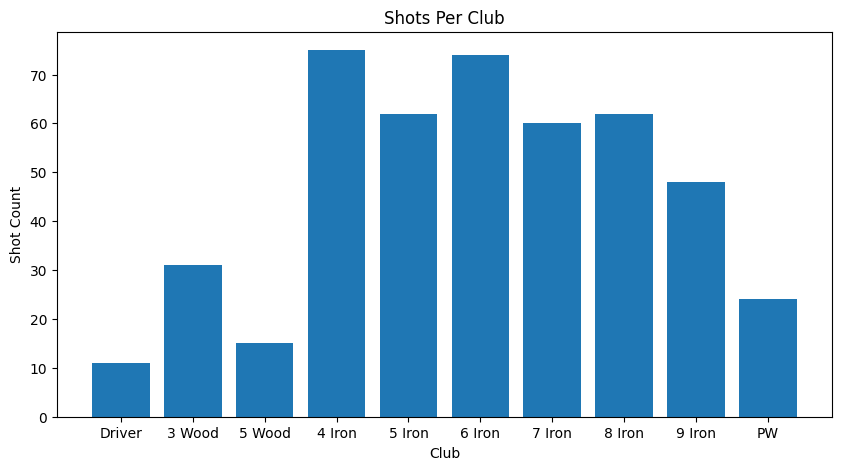

In [13]:
value_counts = df['Club Type'].value_counts()
value_counts = fixIndexes(value_counts)
plt.figure(figsize=(10, 5))
plt.bar(value_counts.index, value_counts)
plt.ylabel('Shot Count')
plt.xlabel('Club')
plt.title('Shots Per Club')

plt.show()

## Outlier Detection

To ensure the quality and reliability of the dataset, I visualized key metrics such as ball speed, launch angle, and carry distance to identify potential outliers.

These outliers could represent mishits, measurement errors, or inconsistent swings. Detecting and understanding them is important for refining the analysis and drawing accurate conclusions. Scatter plots and histograms were used to efficiently highlight unusual data points that deviate significantly from typical shot patterns.

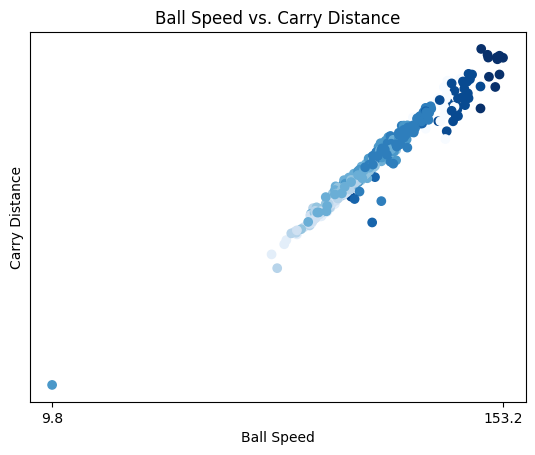

In [14]:
xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()

plt.xticks([max_speed, min_speed])
plt.yticks([])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance')
plt.show()

Removing the outlier

In [15]:
min_index = df['Carry Distance'].idxmin()
df = df.drop(min_index)

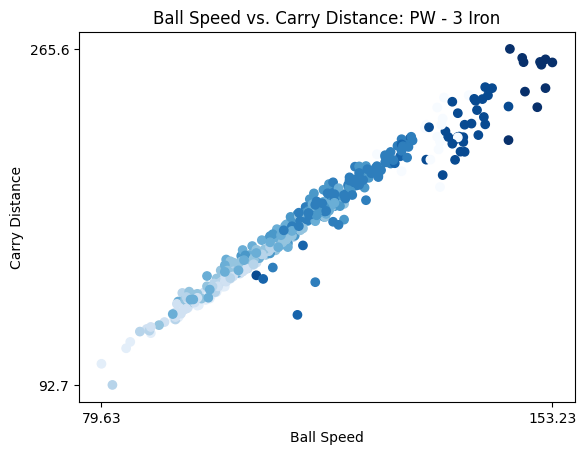

In [16]:
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

This looks much better, now I will remove some more outliers that are a result of a broken 3 iron.

In [17]:
#remove the 3 3-iron outliers
df = df[df['Club Type'] != '3 Iron']

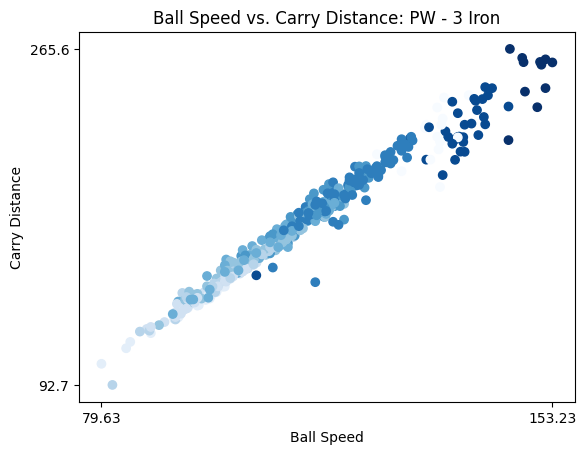

In [18]:
# looking at the same plot to verify the outliers have been removed
max_speed = df['Ball Speed'].max()
min_speed = df['Ball Speed'].min()
max_dist = df['Carry Distance'].max()
min_dist = df['Carry Distance'].min()

xpoints = df['Ball Speed']
ypoints = df['Carry Distance']

plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

plt.xticks([max_speed, min_speed])
plt.yticks([min_dist, max_dist])
plt.xlabel('Ball Speed')
plt.ylabel('Carry Distance')
plt.title('Ball Speed vs. Carry Distance: PW - 3 Iron')
plt.show()

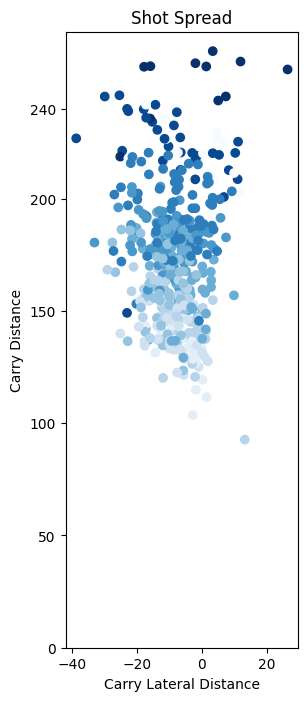

In [19]:
ypoints = df['Carry Distance']
xpoints = df['Carry Lateral Distance']


plt.figure(figsize=(3, 8))
plt.scatter(xpoints, ypoints, c=df['Club Color'], cmap='Blues', label='Club Type')

#plt.xticks([max_speed, min_speed])
plt.yticks([0, 50, 100, 150,200,240])
plt.ylabel('Carry Distance')
plt.xlabel('Carry Lateral Distance')
plt.title('Shot Spread')
plt.show()

Looking at a 3 dimensional plot that shows lateral carry, carry, and peak height, we can see that there are a couple of outliers that have a peak height below 20 ft. These are most likely "shanks". I am going to remove these from the dataset as I don't want these to skew the data.

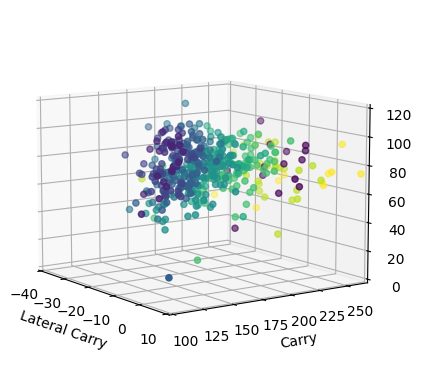

In [20]:
ax = plt.figure().add_subplot(projection='3d')
y=df['Carry Distance'].astype(int)
z=df['Peak Height'].astype(int)
x=df['Carry Lateral Distance'].astype(int)
  
ax.view_init(-170,  35) 

ax.scatter(x, y, z, c=df['Club Color'], marker='o')

# Make legend, set axes limits and labels
ax.set_xlim(10, -40)
ax.set_ylim(100, 265)
ax.set_zlim(120, 0)
ax.set_xlabel('Lateral Carry')
ax.set_ylabel('Carry')
ax.set_zlabel('Peak Height')


plt.show()

In [21]:
mean_by_club = round(df.groupby('Club Type')['Carry Distance'].mean(), 2)
min_by_club = round(df.groupby('Club Type')['Carry Distance'].min(), 2)
max_by_club = round(df.groupby('Club Type')['Carry Distance'].max(), 2)

mean_by_club = fixIndexes(mean_by_club)
max_by_club = fixIndexes(max_by_club)
min_by_club = fixIndexes(min_by_club)

In [22]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center', bbox = dict(facecolor = 'skyblue', alpha =.7, mouseover=True))

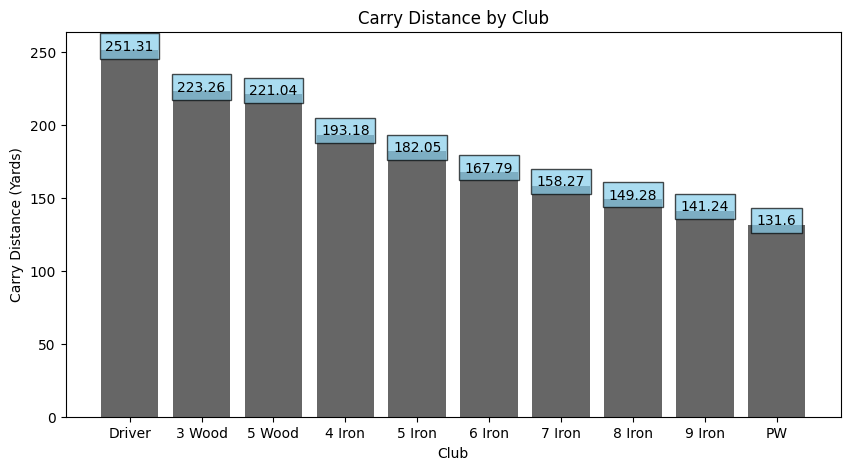

In [23]:
colors = plt.cm.Accent(df['Club Color'])
plt.figure(figsize=(10, 5))
plt.bar(mean_by_club.index, mean_by_club.values, color=colors)
addlabels(mean_by_club.index, mean_by_club.values)
plt.ylabel('Carry Distance (Yards)')
plt.xlabel('Club')
plt.title('Carry Distance by Club')
mplc.cursor(hover=True)
plt.show()


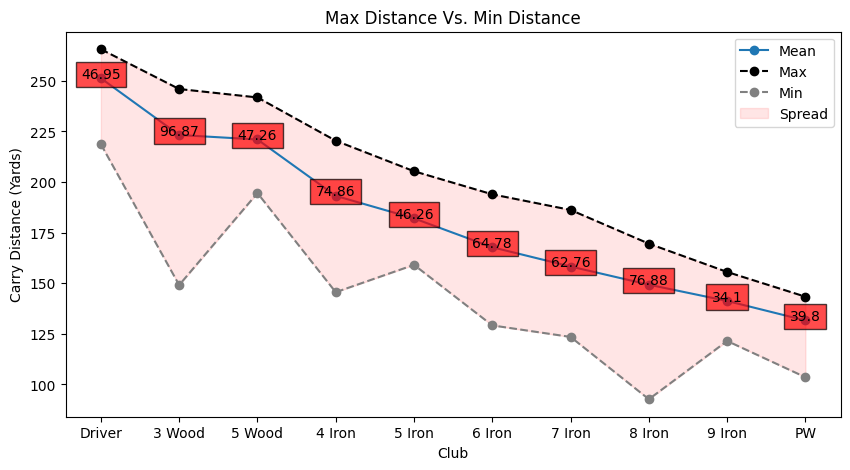

In [24]:
def addlabelMidpoint(x,y, colr):
    for i in range(len(x)):
        plt.text(i, mean_by_club.values[i], round(y[i],2), ha = 'center', bbox = dict(facecolor = colr, alpha =.7, mouseover=True))

# Calculate distance and midpoint (example at x=3)
diff = max_by_club.values - min_by_club.values
midpoint = (max_by_club.values - min_by_club.values)/2
plt.figure(figsize=(10, 5))
mid_color = 'red'
addlabelMidpoint(mean_by_club.index, diff, mid_color)

plt.plot(mean_by_club.index, mean_by_club.values, marker='o')
plt.plot(max_by_club.index, max_by_club.values, color='black', linestyle='--', marker='o')
plt.plot(min_by_club.index, min_by_club.values, color='grey', linestyle='--', marker='o')
plt.fill_between(mean_by_club.index, max_by_club.values, min_by_club.values, alpha=0.1, color='red')

plt.title('Max Distance Vs. Min Distance')
plt.legend(['Mean', 'Max', 'Min', 'Spread'])
plt.xlabel('Club')
plt.ylabel('Carry Distance (Yards)')
plt.show()

In [25]:
q1 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.25), 2)
q2 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.5), 2)
q3 = round(df.groupby('Club Type')['Carry Distance'].quantile(0.75), 2)
q1 = fixIndexes(q1)
q2 = fixIndexes(q2)
q3 = fixIndexes(q3)


/var/folders/3h/h97fc_615jxbc5q34dt7lkk00000gn/T/ipykernel_12290/3578635194.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(q1.index, fontsize = 7)
/var/folders/3h/h97fc_615jxbc5q34dt7lkk00000gn/T/ipykernel_12290/3578635194.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(q2.index, fontsize = 7)


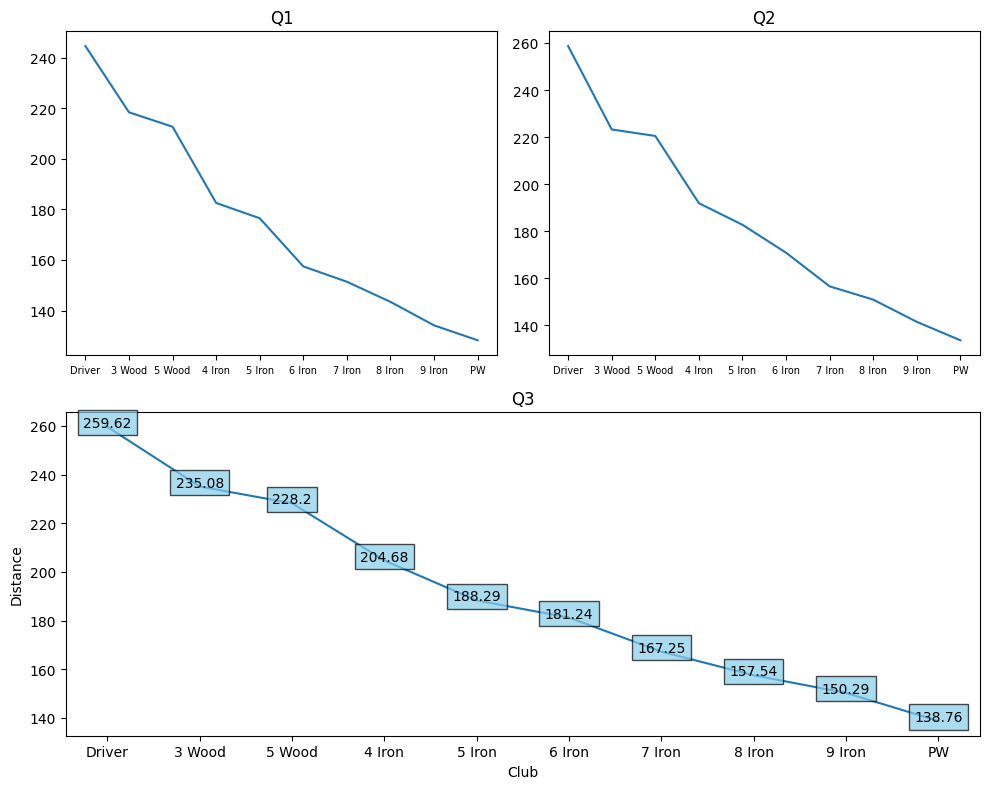

In [26]:
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.plot(q1.index, q1.values)
ax1.set_title('Q1')
ax1.set_xticklabels(q1.index, fontsize = 7)

ax2.plot(q2.index, q2.values)
ax2.set_title('Q2')
ax2.set_xticklabels(q2.index, fontsize = 7)

ax3.plot(q3.index, q3.values)
ax3.set_title('Q3')
ax3.set_ylabel('Distance')
ax3.set_xlabel('Club')
addlabels(q3.index, q3.values)

plt.tight_layout()
plt.show()

## Web Scraping

For fun—and to add context—I decided to pull data on the average carry distances of professional golfers on the PGA Tour. This allows me to compare my performance against elite players (spoiler: the results aren’t exactly close).

Using web scraping, I extracted distance data from publicly available PGA sources to include in my analysis.

I used Python’s requests and BeautifulSoup libraries to scrape data from Golf Monthly. The script extracts a specific HTML table containing carry distances, club speed, ball speed, and spin rates for each club in a typical PGA Tour player's bag.

The parsed data is stored in a Pandas DataFrame and visualized alongside my own average carry distances to highlight the performance gap.

In [27]:
r = requests.get('https://www.golfmonthly.com/tour/how-far-pga-tour-players-hit-every-club-in-the-bag')

# check status code for response received
# success code - 200
print(r)

soup = BeautifulSoup(r.content, 'html.parser')

print('Classes of each table:')
for table in soup.find_all('table'):
    print(table.get('class'))

<Response [200]>
Classes of each table:
['table__wrapper', 'table__wrapper--inbodyContent', 'table__wrapper--sticky', 'table__wrapper--divider']


In [28]:
# Creating list with all tables
tables = soup.find_all('table')

#  Looking for the table with the correct class
table = soup.find('table', class_='table__wrapper table__wrapper--inbodyContent table__wrapper--sticky table__wrapper--divider')

In [29]:
pro_df = pd.DataFrame(columns=['Club', 'Club Speed', 'Ball Speed', 'Spin Rate', 'Carry'])

club = []
club_speed = []
ball_speed = []
spin = []
carry = []

for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    
    if(columns != []):
        club.append(columns[0].text.strip())
        club_speed.append(columns[1].text.strip())
        ball_speed.append(columns[2].text.strip())
        spin.append(columns[3].text.strip())
        carry.append(columns[4].text.strip())

print(club)
pro_df['Club'] = club
pro_df['Club Speed'] = club_speed
pro_df['Ball Speed'] = ball_speed
pro_df['Spin Rate'] = spin
pro_df['Carry'] = carry

pro_df

['Driver', '3-Wood', '5-Wood', 'Hybrid', '3-Iron', '4-Iron', '5-Iron', '6-Iron', '7-Iron', '8-Iron', '9-Iron', 'Pitching Wedge']


,Club,Club Speed,Ball Speed,Spin Rate,Carry
0,Driver,115,171,2545,282
1,3-Wood,110,162,3663,249
2,5-Wood,106,156,4322,236
3,Hybrid,102,149,4587,231
4,3-Iron,100,145,4404,218
5,4-Iron,98,140,4782,209
6,5-Iron,96,135,5280,199
7,6-Iron,94,130,6204,188
8,7-Iron,92,123,7124,176
9,8-Iron,89,118,8078,164


In [30]:
# converting values to floats
pro_df['Club Speed'] = pd.to_numeric(pro_df['Club Speed'])
pro_df['Ball Speed'] = pd.to_numeric(pro_df['Ball Speed'])
pro_df['Spin Rate'] = pd.to_numeric(pro_df['Spin Rate'])
pro_df['Carry'] = pd.to_numeric(pro_df['Carry'])

# renaming club values to match my data
pro_df.replace('4-Iron', '4 Iron', inplace=True)
pro_df.replace('5-Iron', '5 Iron', inplace=True)
pro_df.replace('6-Iron', '6 Iron', inplace=True)
pro_df.replace('7-Iron', '7 Iron', inplace=True)
pro_df.replace('8-Iron', '8 Iron', inplace=True)
pro_df.replace('9-Iron', '9 Iron', inplace=True)
pro_df.replace('3-Wood', '3 Wood', inplace=True)
pro_df.replace('5-Wood', '5 Wood', inplace=True)
pro_df.replace('Pitching Wedge', 'PW', inplace=True)

# dropping the club types that I do not have my own data for
pro_df.drop(index=[3, 4], inplace=True)
pro_df = pro_df.reset_index(drop=True)

pro_df


,Club,Club Speed,Ball Speed,Spin Rate,Carry
0,Driver,115,171,2545,282
1,3 Wood,110,162,3663,249
2,5 Wood,106,156,4322,236
3,4 Iron,98,140,4782,209
4,5 Iron,96,135,5280,199
5,6 Iron,94,130,6204,188
6,7 Iron,92,123,7124,176
7,8 Iron,89,118,8078,164
8,9 Iron,87,112,8793,152
9,PW,84,104,9316,142


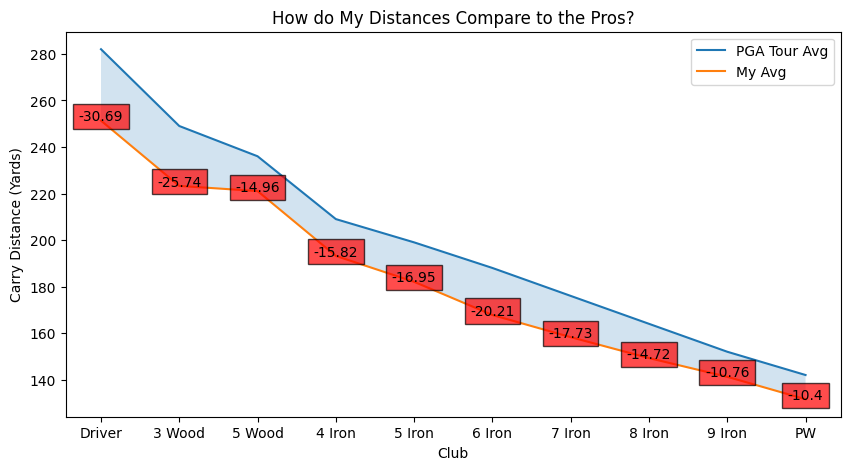

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(pro_df['Club'], pro_df['Carry'])
plt.plot(mean_by_club.index, mean_by_club.values)
plt.fill_between(mean_by_club.index, mean_by_club.values, pro_df['Carry'], alpha=0.2, label='Area between curves')
plt.title('How do My Distances Compare to the Pros?')
plt.legend(['PGA Tour Avg', 'My Avg'])
plt.xlabel('Club')
plt.ylabel('Carry Distance (Yards)')
diff = pro_df['Carry'] - mean_by_club.values

addlabelMidpoint(mean_by_club.index, -diff, mid_color)

plt.show()

## Enough About Distance — Let’s Talk Accuracy

The Awesome Golf app includes a separate training mode focused on accuracy, where you can aim at various targets set at different distances. The app tracks key metrics such as:

- Number of shots taken at each target

- Number of times the green was hit

- Number of shots that finished within 10 feet of the hole

Unfortunately, the app doesn't offer an option to export this data, so I’ve entered it manually. Thankfully, the dataset is relatively small. Below is a screenshot of the accuracy data I collected during this target practice session.

It's worth noting that the greens in this training mode are very large, making them easier to hit than on a real course. As a result, my real-world accuracy would likely be lower than what's reflected in this session.

<img src="approach_data.jpeg" alt="drawing" width="200"/>

In [32]:
approach_data = {
    "shots": [50, 348,299,136],
    "greens hit": [32, 214, 199, 53],
    "inside 10": [14, 34,13,4],
    "Distance": ["0-99", "100-149", "150-199", "200+"]
}

approach_df = pd.DataFrame(approach_data)

approach_df.head()


,shots,greens hit,inside 10,Distance
0,50,32,14,0-99
1,348,214,34,100-149
2,299,199,13,150-199
3,136,53,4,200+


In [33]:
approach_df['green hit prob'] = round(approach_df['greens hit'] / approach_df['shots'], 2)
approach_df['inside 10 prob'] = round(approach_df['inside 10'] / approach_df['shots'], 2)

approach_df.head()

,shots,greens hit,inside 10,Distance,green hit prob,inside 10 prob
0,50,32,14,0-99,0.64,0.28
1,348,214,34,100-149,0.61,0.10
2,299,199,13,150-199,0.67,0.04
3,136,53,4,200+,0.39,0.03


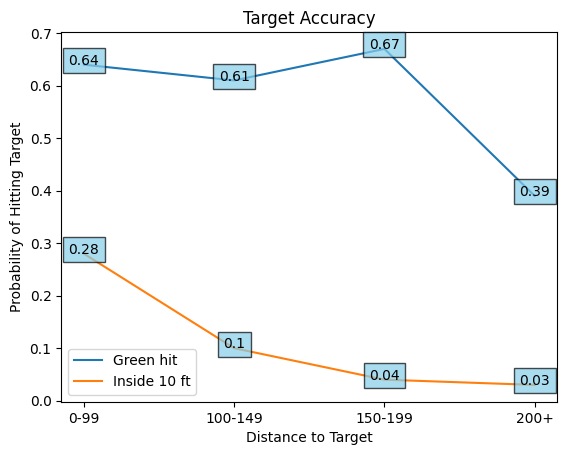

In [34]:
plt.plot(approach_df['Distance'], approach_df['green hit prob'])
plt.plot(approach_df['Distance'], approach_df['inside 10 prob'])
plt.xlabel('Distance to Target')
plt.ylabel('Probability of Hitting Target')
plt.title('Target Accuracy')
addlabels(approach_df['Distance'], approach_df['green hit prob'])
addlabels(approach_df['Distance'], approach_df['inside 10 prob'])
plt.legend(["Green hit", "Inside 10 ft"], loc="lower left")
plt.show()

Exporting the final dataframes to new .csv files.

In [35]:
pro_df.to_csv('shot_csvs/output/pro_stats.csv')
approach_df.to_csv('shot_csvs/output/approach_stats.csv')
df.to_csv('shot_csvs/output/combined_and_cleaned.csv')

Finally, I want to calculate the probability of making a hole in one from these various distances

In [36]:
def calculateHoleInOneProb(df):
    ten_ft_area = math.pi * (60**2)
    hole_area = math.pi * (2.125**2)
    hole_in_one_prob = hole_area / ten_ft_area

    #confirm required columns are in the dataframe
    cols = ['inside 10 prob', 'Distance']
    columns_exist = pd.Series(cols).isin(df.columns).all()
    if columns_exist:
        # if required columns exist, calculate probability
        # of hole in one from each distance
        p = []
        for idx, row in df.iterrows():
            p.append(hole_in_one_prob * df.loc[idx, 'inside 10 prob'])
        df['P of HIO'] = p
        # printing the results
        df_subset = df[['Distance', 'P of HIO']]
        df_combined = pd.concat([df_subset], axis=1)
        print(df_combined.to_string())
            
    else:
        #not all required columns exist, exit the function
        print("Not all specified columns are present.")

In [37]:
calculateHoleInOneProb(approach_df)

  Distance  P of HIO
0     0-99  0.000351
1  100-149  0.000125
2  150-199  0.000050
3     200+  0.000038


## Conclusion

The data reveals significant distance gaps between my 4-iron and 5-iron, as well as between my 6-iron and 7-iron. This suggests I need to focus on increasing the distance I achieve with my 5-iron and 7-iron to create more consistent spacing between clubs. Additionally, most of my clubs fall about 16–20 yards shorter than the averages for professional golfers. While this isn’t surprising—given the amount of training professionals undergo—it was interesting to see the comparison and highlights areas where I have room to improve.

I also noticed that the variability in shot quality is highest with my 8-iron and 4-iron. This indicates a need to work on consistency with those two clubs in particular.

Another key insight is the tendency for my longer clubs—specifically the 4-iron, 3-wood, and driver—to produce shots that drift to the right, commonly known as a slice. This has been a persistent challenge since I began golfing as a child, and it’s reassuring to see the radar device capturing that tendency accurately. The alignment between the data and my on-course experience increases my confidence in the validity of the metrics being collected.

If you’ve made it this far—thank you! If you’d like to play a round or are hiring a data analyst, feel free to connect with me on LinkedIn. I’m always looking for people to golf with, and I’m currently exploring new opportunities.

<a href="https://www.linkedin.com/in/jonathan-jacobson-8919a3291/">LinkedIn</a>

<a href="https://joja4479.github.io/">Portfolio</a>

<a href="mailto:joja4479@colorado.edu">Email</a> 